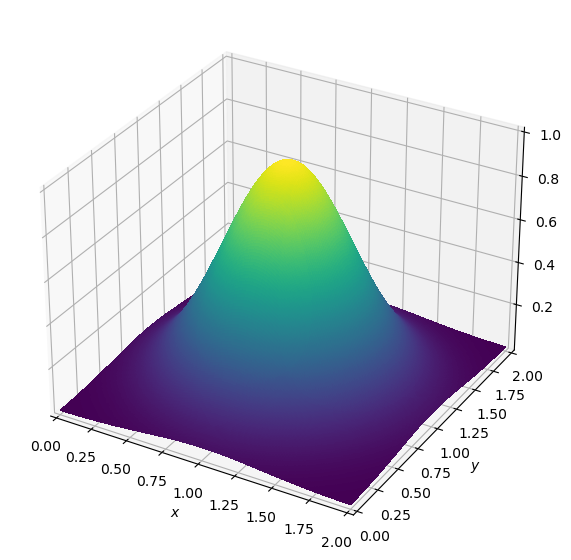

In [1]:
from examples.cfd import  plot_field
import numpy as np
from devito import *
from AI4Advection_Diffusion import Couple_PDE_Solver
from filter.filter_generator import coupling_eq
def init_smooth(field, dx, dy):
    nx, ny = field.shape
    x = np.linspace(0, (nx-1)*dx, nx)
    y = np.linspace(0, (ny-1)*dy, ny)
    X, Y = np.meshgrid(x, y, indexing='ij')
    
    # 使用高斯分布初始化平滑场
    sigma = 0.2
    field[:] = np.exp(-((X-nx*dx/2)**2 + (Y-ny*dy/2)**2) / (2*sigma**2))
    
nt = 100  # Number of timesteps
dt = 0.001  # Timestep size (sigma=0.2)
c = 0.5  # Value for c
nx = 256
ny = 256
length = 1
dx = length/nx
dy = length/ny
# Then we create a grid and our function
grid = Grid(shape=(nx, ny), extent=(length,length))
u = TimeFunction(name='u', grid=grid,time_order = 2, space_order = 2)
v = TimeFunction(name='v', grid=grid,time_order = 2, space_order = 2)

init_smooth(field=u.data[0], dx=grid.spacing[0], dy=grid.spacing[1])
init_smooth(field=v.data[0], dx=grid.spacing[0], dy=grid.spacing[1])

plot_field(v.data[0])

In [2]:

eq1 = Eq(u.dt + c*u.dx + c*u.dy + 3*(u - v))
eq2 = Eq(v.dt + c*v.dx + c*v.dy + 3*(v - u))

In [3]:
model = Couple_PDE_Solver([eq1,eq2],[u,v],dx,dy,dt,nx,ny,coupling_eq)

In [4]:
for t in range(1,nt):
    model = Couple_PDE_Solver([eq1,eq2],[u,v],dx,dy,dt,nx,ny,coupling_eq)
    a, b = model.forward()
    a, b = a.detach().numpy().squeeze(0).squeeze(0), b.detach().numpy().squeeze(0).squeeze(0)
    np.save(f'./coupling_equation/u{t}.npy',a)
    np.save(f'./coupling_equation/v{t}.npy',b)
    u.data[0] = a
    v.data[0] = b

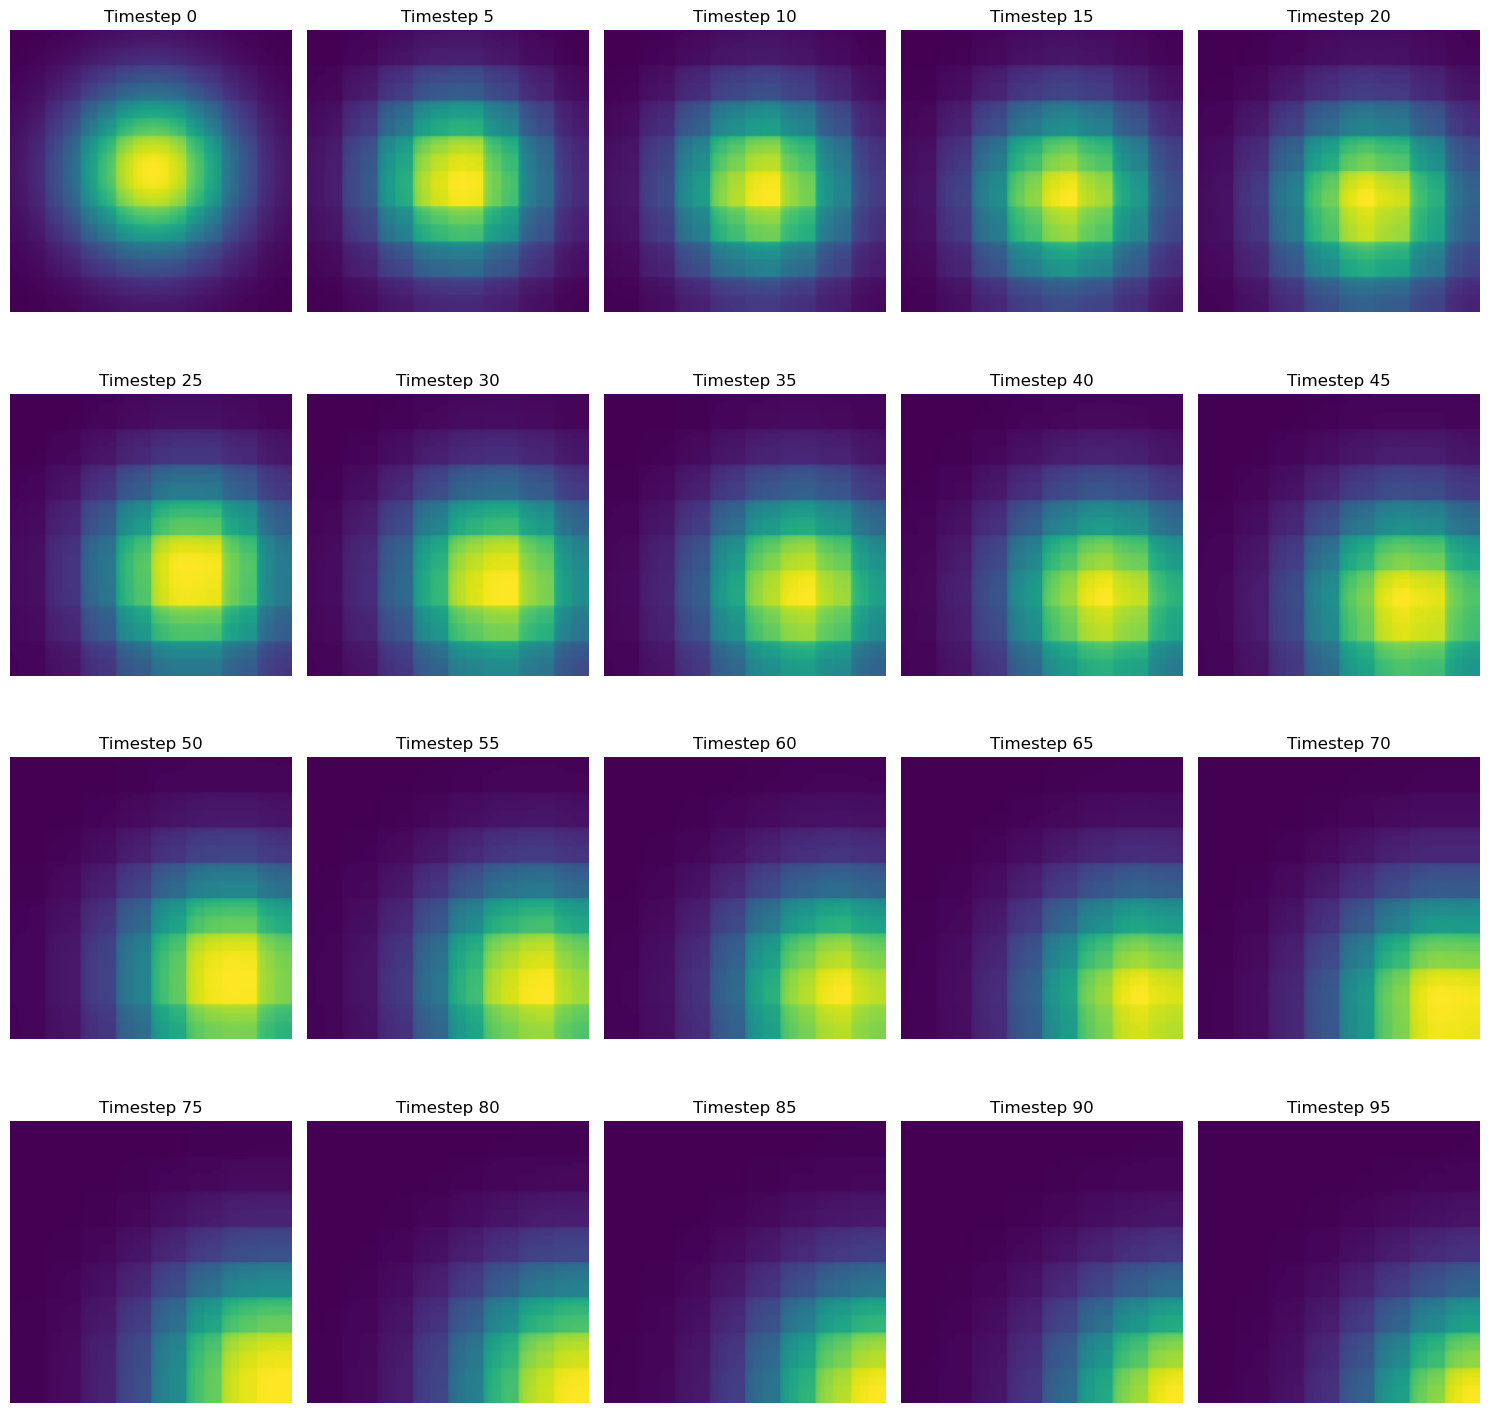

In [5]:
import matplotlib.pyplot as plt
tensors = []
for i in range(1, nt, 5):
    tensor = np.load(f'./coupling_equation/u{i}.npy')
    tensors.append(tensor)

fig, axes = plt.subplots(nrows=len(tensors)//5, ncols=5, figsize=(15, 15))

for idx, tensor in enumerate(tensors):
    ax = axes[idx // 5, idx % 5]
    data = tensor
    ax.imshow(data, cmap='viridis', origin='lower')
    ax.set_title(f'Timestep {idx*5}')
    ax.axis('off')  

plt.tight_layout()
plt.show()

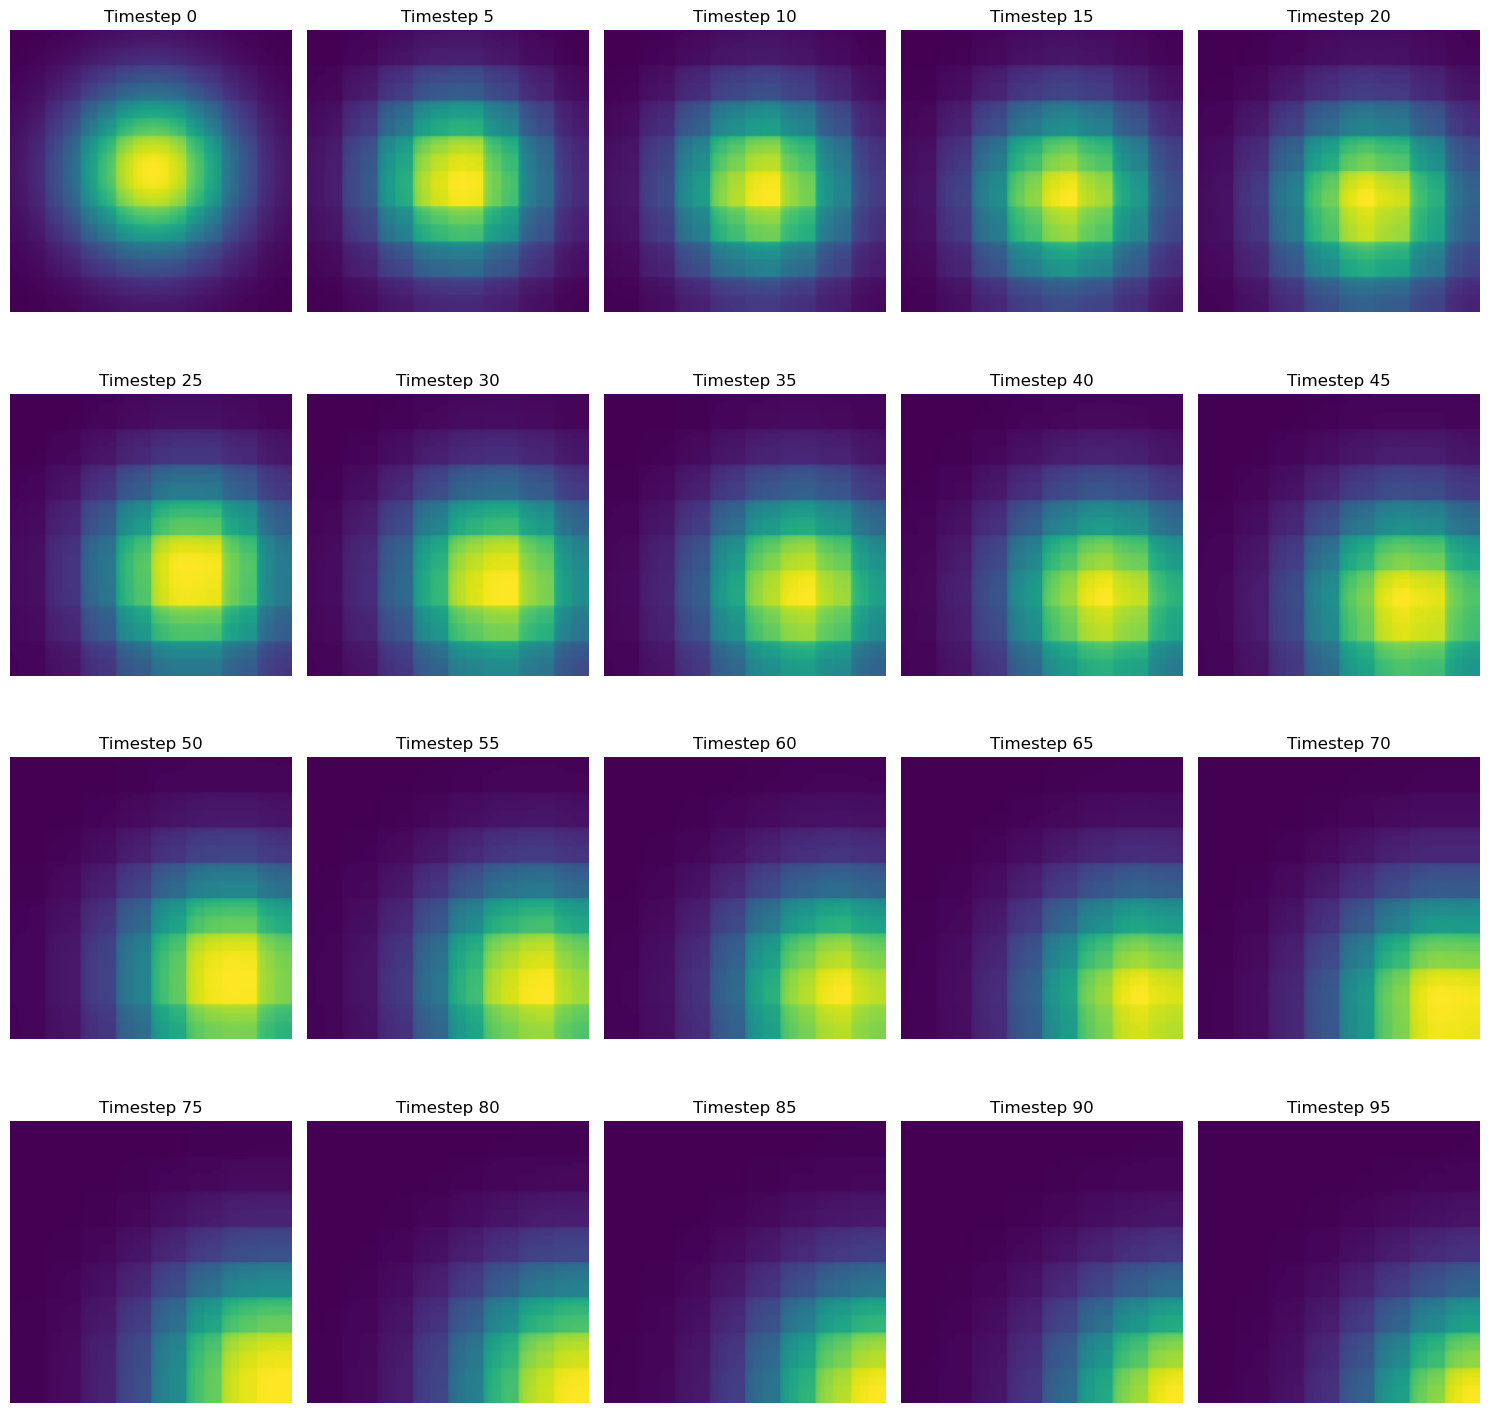

In [6]:
import matplotlib.pyplot as plt
tensors = []
for i in range(1, nt, 5):
    tensor = np.load(f'./coupling_equation/v{i}.npy')
    tensors.append(tensor)

fig, axes = plt.subplots(nrows=len(tensors)//5, ncols=5, figsize=(15, 15))

for idx, tensor in enumerate(tensors):
    ax = axes[idx // 5, idx % 5]
    data = tensor
    ax.imshow(data, cmap='viridis', origin='lower')
    ax.set_title(f'Timestep {idx*5}')
    ax.axis('off')  

plt.tight_layout()
plt.show()